# Practice 4: Transmission

We talked today about the value of transmission and its interaction with environmental policies.

We will learn today how to build a model of an electricity market with incomplete regulation ("leakage").

The data and code are based on the paper "Border Carbon Adjustments When Carbon Intensity Varies Across Producers: Evidence from California," by Meredith Fowlie, Claire Petersen, and Mar Reguant.

We first load relevant libraries and set the path.

In [26]:
using Pkg
Pkg.add(["Tables"])

   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [27]:
begin
    using CSV, Tables
    using JuMP  # used for mathematical programming
    using Ipopt  # solver
    using Printf
    using Plots
end

In [28]:
dirpath = "/Users/marreguant/Dropbox/TEACHING/GRAD/Econ_498_2023/module2/practicum/"

"/Users/marreguant/Dropbox/TEACHING/GRAD/Econ_498_2023/module2/practicum/"

## Data

The data have been generated by compiling several publicly-available sources about the market outcomes of the Western interconnection areas. This is a recent dataset (2019 data) benefiting from better availability of data on wind and solar production available at EIA. 

Most of the data are region-hourly, and data on power plants is plant-region.

Here I provide a description of the variables (available in the online appendix as well).

* a: Electricity demanded when price is zero.
* b: Slope of electricity demand curve.
* qmr: Quantity of electricity from wind, solar, nuclear, and hydroelectric energy sources, which “must run” in the model for each region
* mc: Marginal cost of electricity production.
* er: Emissions rate.
* mw: Capacity.
* cf: Capacity factor.
* flag: Dummy variable flagging natural gas units near large cities to mandate a minimum required generation.
* isca: Dummy variable indicating the generating unit is in California.
* istax: Dummy variable indicating the generating unit is in California’s tax jurisdiction.
* lines: Maximum capacity that can flow through transmission lines.
* fct: Distribution of electricity flow originating in a region along the transmission lines.

The files are stored as .CSV matrices, ready to be imported and used in the model. These CSV files were generated by preparation code from raw sources and are subject to assumptions, e.g., for the marginal cost of the power plants and clustering techniques to simplify the regions and the number of observations.

In [11]:
begin
    # we load a bunch of matrices that were created via other datasets
    datasets = ["a","b","cf","er","fct","flag","fuel",
        "isca","ischp","istax","lines",
        "mc","mw","qmr","qrw","w"];

    # we put them into data
    data = Dict{String,Any}();
    for x in datasets
        data[string(x)] = CSV.File(string(dirpath,"data_leakage/",x,".csv"), header=false) |> Tables.matrix;
    end
end

In [12]:
data["a"]  # intercept of demand for 4 regions and 100 periods

4×100 Matrix{Float64}:
 33.1375   30.005    36.6204  28.4611   …  33.4986  40.5096   26.1449
 33.8523   29.3415   42.0462  31.6467      41.5628  38.3515   26.8072
 12.2017   13.1445   14.2157  10.9905      12.4546  19.2729   10.1063
  8.44305   7.52042  10.5337   8.11629      9.768    9.21859   7.07419

In [13]:
data["mc"] # Marginal cost of each utility providing electricity to each of the 4 regions

4×220 Matrix{Float64}:
 16.1512  22.3162  22.7297  22.7307  22.8237  …   257.447   543.21  4035.54
 16.0538  16.1817  16.241   16.6351  19.4467     1000.0    1000.0   1000.0
 16.8223  19.4049  19.4324  19.5312  19.5602     1000.0    1000.0   1000.0
 16.2785  21.2949  21.5197  21.7047  24.2688     1000.0    1000.0   1000.0

In [14]:
data["istax"] # whether a power plant is taxed or not by the policy

4×220 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

**Note:** We can explore how the network is specified (see slides 85 / 86 from lecture 3). We have 5 lines: (4 to 2 and 3, 2 and 3 to 1 and 2 to 3) with a maximum capacity.

With that, every unit of electricity produced in each of the 4 regions will flow across regions according to flow factors `fct` (taking CA as reference)  


In [15]:
df_lines = Dict("lines" => data["lines"], "flow" =>data["fct"])

Dict{String, Matrix{Float64}} with 2 entries:
  "lines" => [6.85; 7.13; … ; 1.1075; 1.145;;]
  "flow"  => [0.623 0.378 … 0.144 0.234; 0.378 0.623 … -0.144 -0.234; 0.5 0.5 ……

## Model

We will be solving the model using the "maximization" approach of optimizing economic surprlus. This will save us from coding up the transmission lines constraints using mixed integer programming. 

The same "mazimization" approach is used in the paper "Strategic Policy Choice in State-Level Regulation: The EPA's Clean Power Plan." by Bushnell, James B., Stephen P. Holland, Jonathan E. Hughes, and Christopher R. Knittel. We build on this model, which is available in AMPL at [http://doi.org/10.3886/E114648V1](http://doi.org/10.3886/E114648V1).

In comparison, one big limitation of our short conference paper is that it does not include investment.


The model follows similar steps from last week:

1. Declare the model to initialize it. We also call it "model" here, but it could be any name.

2. Declare some useful indices to keep track of regions, plants, and lines. [Note: There is no time here because the function will only solve one hour at a time]

3. [New] Declare some parameters as a function of the policy case, which is an input to the function. 

4. Declare variables.

5. Declare objective function.

6. Declare constraints, [New] including those for the environmental regulation and the transmission lines.


### Adding transimission and carbon taxes

We will start by considering the case where all electricity producers are regulated under the same carbon pricing regime.


In [29]:
function clear_market_at_t_simple(d::Dict{String,Any};
    t=1, tax=17.0)

    model = Model(
    optimizer_with_attributes(
        Ipopt.Optimizer, "print_level"=>0)
    );

    # Set market inputs
    R = size(d["a"],1);  # number of regions
    U = size(d["mc"],2); #number of utilities
    L = size(d["lines"],1); #number of lines

    p0 = d["a"]./d["b"] #auxiliary parameter to don't write everytime a/b

    # define costs of carbon: all emissions are taxed uniformly
    er_tax = d["er"] 

    # variables to solve for
    @variable(model, price[1:R]);
    @variable(model, demand[1:R]);
    @variable(model, yflow[1:R-1]);  # swing node is CA. How much is being sent to CA (y < 0 implies that CA is exporting)
    @variable(model, q[1:R, 1:U]>=0);

    # summary variables (function of variables to solve):
    @variable(model, surplus);
    @variable(model, totalcost);  # fuel cost
    @variable(model, totalecost);  # taxed emissions costs
    @variable(model, totale[1:R]); #total emissions

    # definition of objective function
    @NLobjective(model, Max, surplus - totalcost - totalecost);


    @constraint(model, surplus == sum(0.5 * (p0[r, t] + price[r]) * demand[r] for r in 1:R));
    @constraint(model, totalcost == sum(q[r,i] * d["mc"][r, i] for r in 1:R, i in 1: U));
    @constraint(model, totalecost == sum(q[r, i] * d["er"][r, i] * tax for r in 1:R, i in 1: U));
    @constraint(model, [r=1:R], totale[r] == sum(q[r, i] * d["er"][r, i] for i in 1: U));

    # definition demand
    @constraint(model, [r=1:R], demand[r] == (d["a"][r, t] - d["b"][r, t] * price[r]));

    # constraint quantities to 95% of name plate capacity
    @constraint(model, [r=1:R, i=1:U], q[r, i] <= 0.95 *  d["mw"][r, i]/1000.0); #mw = capacity

    # congestion constraint: we require a minimum generation for some units
    @constraint(model, [r=1:R, i=1:U], q[r, i] >= d["cf"][r, i] * d["flag"][r, i] * d["mw"][r, i]/1000.0);
    #cf=capacity factor (similar to the 0.95 above)
    
    # market clearing: demand = production in CA + renewables + imports (or - exports)
    @constraint(model, demand[1] == sum(q[1,i] for i=1:U) + d["qmr"][1, t] + sum(yflow[z] for z in 1:R-1));
    @constraint(model, [r=2:R], demand[r] + yflow[r-1] == sum(q[r,i] for i=1:U) + d["qmr"][r, t]);
    
    # transmission line
    @constraint(model, [l=1:L], sum(d["fct"][z,l] * yflow[z] for z in 1:R-1) <= d["lines"][l]);
    @constraint(model, [l=1:L], sum(d["fct"][z,l] * yflow[z] for z in 1:R-1) >= -d["lines"][l]); #see appendix

    optimize!(model)

    status = @sprintf("%s",JuMP.termination_status(model));

    if ((status=="LOCALLY_SOLVED") | (status=="ALMOST_LOCALLY_SOLVED"))
    results = Dict("status" => status,
            "surplus" => JuMP.value.(surplus),
            "totalcost" => JuMP.value.(totalcost),
            "totalecost" => JuMP.value.(totalecost),
            "totale" => JuMP.value.(totale),
            "price" => JuMP.value.(price),
            "demand" => JuMP.value.(demand),
            "yflow" => JuMP.value.(yflow),
            "q" => JuMP.value.(q));
    return results
    else
    results = Dict("status" => status);
    return results
    end

end


clear_market_at_t_simple (generic function with 1 method)

In [30]:
results_baseline= clear_market_at_t_simple(data, tax=0.0)


Dict{String, Any} with 9 entries:
  "yflow"      => [3.20006, 8.09323, -0.805769]
  "totalcost"  => 1126.49
  "price"      => [27.5399, 28.1843, 26.8956, 28.0744]
  "status"     => "LOCALLY_SOLVED"
  "demand"     => [30.6588, 31.0824, 11.0051, 7.73113]
  "totalecost" => 0.0
  "surplus"    => 14909.9
  "totale"     => [4.00097, 12.7604, 6.09683, 4.17486]
  "q"          => [0.033605 0.0243024 … -9.99028e-9 -9.99875e-9; 0.0347595 0.02…

### Adding leakage regulation and reshuffling 

Now we augment the model to consider several cases.

1. No regulation, tax is 0.
2. Uniform tax, every region (it corresponds to the case discussed above).
3. CA tax only.
4. Tax of imports at default rate, with opt-out.
5. Tax of imports at default rate, no opt-out.

In [18]:
function clear_market_at_t(d::Dict{String,Any};
        t=1, case=2, tax=17.0, default=0.428)

    model = Model(
        optimizer_with_attributes(
            Ipopt.Optimizer, "print_level"=>0)
        );

    # Set market inputs
    R = size(d["a"],1);  # number of regions
    U = size(d["mc"],2); #number of utilities
    L = size(d["lines"],1); #number of lines

    p0 = d["a"]./d["b"] #auxiliary parameter to don't write everytime a/b

    # define costs of carbon depending on policy
    if  case==1  # no regulation
        er_tax = d["er"];
        tax = 0.0;
    elseif case==2  # uniform tax
        er_tax = d["er"]; #tax already defined
    elseif case==3  # only CA tax
        er_tax = d["er"] .* d["istax"];
    elseif case==4  # opt-out default
        er_tax = d["er"] .* d["istax"] .+ ((d["er"] .> default) .* default 
            + (d["er"] .<= default) .* d["er"]) .* (1. .- d["istax"]);
    elseif case==5  # mandatory default
        er_tax = d["er"] .* d["istax"] .+ default .* (1. .- d["istax"]);
    else
        return @printf("Invalid case");
    end

    # variables to solve for
    @variable(model, price[1:R]);
    @variable(model, demand[1:R]);
    @variable(model, yflow[1:R-1]);  # swing node is CA. How much is being sent to CA (y < 0 implies that CA is exporting)
    @variable(model, q[1:R, 1:U]>=0);
    @variable(model, q_ca[1:R, 1:U]>=0);  # quantity sent to CA for accounting purposes. 
    @variable(model, qmr_ca[1:R]>=0);  # quantity must-run sent to CA (no emissions): hydro and renewables

    # summary variables (function of variables to solve):
    @variable(model, surplus);
    @variable(model, totalcost);  # fuel cost
    @variable(model, totalecost);  # taxed emissions costs
    @variable(model, totale[1:R]); #total emissions
    @variable(model, totale_ca);  # emissions based on accounting quantity
    @variable(model, totale_ca_claimed);  # emissions based on accounting quantity but the true rate 
    @variable(model, totale_ca_instate);  # emissions based on accounting quantity but the true rate 

    # definition of objective function
    @NLobjective(model, Max, surplus - totalcost - totalecost);

    
    @constraint(model, surplus == sum(0.5 * (p0[r, t] + price[r]) * demand[r] for r in 1:R));
    @constraint(model, totalcost == sum(q[r,i] * d["mc"][r, i] for r in 1:R, i in 1: U));
    if case==2
        @constraint(model, totalecost == sum(q[r, i] * d["er"][r, i] * tax for r in 1:R, i in 1: U));
    elseif case==5
        @constraint(model, totalecost == sum(q_ca[r, i] * er_tax[r, i] * tax for r in 1:R, i in 1: U) 
            + sum(qmr_ca[r] * default * tax for r in 2:R)); #sources that are emission-free also pay
    else
        @constraint(model, totalecost == sum(q_ca[r, i] * er_tax[r, i] * tax for r in 1:R, i in 1: U));        
    end
    @constraint(model, [r=1:R], totale[r] == sum(q[r, i] * d["er"][r, i] for i in 1: U));
    @constraint(model,	totale_ca == sum(q_ca[r, i] * d["er"][r, i] for r in 1:R, i in 1: U));
    @constraint(model, totale_ca_instate == 
        sum(q_ca[r, i] * d["er"][r, i] * d["isca"][r, i] for r in 1:R, i in 1: U));
    if case==5
        @constraint(model, totale_ca_claimed == sum(q_ca[r, i] * er_tax[r, i] for r in 1:R, i in 1: U) 
            + sum(qmr_ca[r] * default for r in 2:R));
    else
        @constraint(model, totale_ca_claimed == sum(q_ca[r, i] * er_tax[r, i] for r in 1:R, i in 1: U));
    end

    # definition demand
    @constraint(model, demand[1] == (d["a"][1, t] - d["b"][1, t] * price[1]));
    @constraint(model, [r=2:R], demand[r] == (d["a"][r, t] - d["b"][r, t] * price[r]));

    # constraint quantities to 95% of name plate capacity
    @constraint(model, [r=1:R, i=1:U], q[r, i] <= 0.95 *  d["mw"][r, i]/1000.0); 

    # congestion constraint
    @constraint(model, [r=1:R, i=1:U], q[r, i] >= d["cf"][r, i] * d["flag"][r, i] * d["mw"][r, i]/1000.0);

    # market clearing
    @constraint(model, demand[1] == sum(q[1,i] for i=1:U) + d["qmr"][1, t] + sum(yflow[z] for z in 1:R-1));
    @constraint(model, [r=2:R], demand[r] + yflow[r-1] == sum(q[r,i] for i=1:U) + d["qmr"][r, t]);

    # transmission line
    @constraint(model, [l=1:L], sum(d["fct"][z,l] * yflow[z] for z in 1:R-1) <= d["lines"][l]);
    @constraint(model, [l=1:L], sum(d["fct"][z,l] * yflow[z] for z in 1:R-1) >= -d["lines"][l]); #see appendix

    # california accounting
    @constraint(model, demand[1] == sum(q_ca[r,i] for r in 1:R, i in 1: U) + sum(qmr_ca[r] for r in 1:R));
    @constraint(model, [r=1:R, i=1:U], q_ca[r, i] <=  q[r, i]);  # CA quantity
    @constraint(model, [r=1:R, i=1:U], q_ca[r, i] >=  d["istax"][r,i] * q[r, i]);  # equal to q if CA/taxed
    @constraint(model, [r=1:R, i=1:U], q_ca[r, i] >=  d["isca"][r,i] * q[r, i]);  # equal to q if CA/taxed
    @constraint(model, qmr_ca[1] == d["qmr"][1, t]);  # equal to q if CA
    @constraint(model, [r=2:R], qmr_ca[r] <=   d["qmr"][r, t]);  # CA quantity from hydro + renewables

    optimize!(model)

    status = @sprintf("%s",JuMP.termination_status(model));
    
    if ((status=="LOCALLY_SOLVED") | (status=="ALMOST_LOCALLY_SOLVED"))
        results = Dict("status" => status,
                "surplus" => JuMP.value.(surplus),
                "totalcost" => JuMP.value.(totalcost),
                "totalecost" => JuMP.value.(totalecost),
                "totale" => JuMP.value.(totale),
                "totale_ca" => JuMP.value.(totale_ca),
                "totale_ca_claimed" => JuMP.value.(totale_ca_claimed),
                "totale_ca_instate" => JuMP.value.(totale_ca_instate),
                "price" => JuMP.value.(price),
                "demand" => JuMP.value.(demand),
                "yflow" => JuMP.value.(yflow),
                "q" => JuMP.value.(q),
                "q_ca" => JuMP.value.(q_ca),
                "qmr_ca" => JuMP.value.(qmr_ca));
        return results
    else
        results = Dict("status" => status);
        return results
    end

end

clear_market_at_t (generic function with 1 method)

In [19]:
results_1 = clear_market_at_t(data, tax=17.0, case=1)

Dict{String, Any} with 14 entries:
  "price"             => [27.5399, 28.1843, 26.8956, 28.0744]
  "totale_ca_claimed" => 10.2493
  "totale_ca"         => 10.2493
  "status"            => "LOCALLY_SOLVED"
  "totalecost"        => 0.0
  "totale"            => [4.00097, 12.7604, 6.09683, 4.17486]
  "q"                 => [0.033605 0.0243024 … -9.99027e-9 -9.99875e-9; 0.03475…
  "demand"            => [30.6588, 31.0824, 11.0051, 7.73113]
  "q_ca"              => [0.033605 0.0243024 … -3.58854e-9 -3.59512e-9; 0.02544…
  "surplus"           => 14909.9
  "totale_ca_instate" => 2.36592
  "yflow"             => [3.20006, 8.09323, -0.805769]
  "totalcost"         => 1126.49
  "qmr_ca"            => [11.6394, 0.0946496, 0.0938531, 0.0911213]

### Creating a function that will run the market for many days

We create a `clear_market_loop` function that will run several days and store the results.


In [20]:
function clear_market_loop(d::Dict{String,Any}; T=100, case=2, tax=17.0, default=0.428)

    # prepare buckets
    status = Any[];
    surplus = Any[];
    totalcost = Any[];
    totalecost = Any[];
    totale = Any[];
    totale_ca = Any[];
    totale_ca_claimed = Any[];
    totale_ca_instate = Any[];
    price = Any[];
    demand = Any[];
    yflow = Any[];
    q = Any[];
    q_ca = Any[];
    qmr_ca = Any[];
    w_mat = Any[];
    
    T = min(T, size(d["a"],2));
    
    for t in 1:T # limit to make computation faster!
        res = clear_market_at_t(data, t=t,
            case=case, tax=tax, default=default)
        if ((res["status"]=="LOCALLY_SOLVED") | (res["status"]=="ALMOST_LOCALLY_SOLVED"))
            push!(status, res["status"]);
            push!(surplus, res["surplus"]);
            push!(surplus, res["surplus"]);
            push!(totalcost, res["totalcost"]);
            push!(totalecost, res["totalecost"]);
            push!(totale, res["totale"]);
            push!(totale_ca, res["totale_ca"]);
            push!(totale_ca_claimed, res["totale_ca_claimed"]);
            push!(totale_ca_instate, res["totale_ca_instate"]);
            push!(price, res["price"]);
            push!(demand, res["demand"]);
            push!(yflow, res["yflow"]);
            push!(q, res["q"]);
            push!(q_ca, res["q_ca"]);
            push!(qmr_ca, res["qmr_ca"]);
            push!(w_mat, d["w"][t]);
        else
            return @sprintf("Hour %d failed with status %s!", t, res["status"]);
        end

    end

    results = Dict("status" => status,
                "surplus" => surplus,
                "totalcost" => totalcost,
                "totalecost" => totalecost,
                "totale" => totale,
                "totale_ca" => totale_ca,
                "totale_ca_claimed" => totale_ca_claimed,
                "totale_ca_instate" => totale_ca_instate,
                "price" => price,
                "demand" => demand,
                "yflow" => yflow,
                "q" => q,
                "q_ca" => q_ca,
                "qmr_ca" => qmr_ca,
                "w" => w_mat);
    
    return results

end

clear_market_loop (generic function with 1 method)

A note on the structure of the data as these things can be very **language-specific**.

The dictionary stores the matrix for each variable and day into the dictionary entry with its variable name. Each day is a separate matrix/vector in itself. So to access day $t$, we use:

`full_results["price"][t]`

which is a vector of regional prices.

In [21]:
Tlimit = 10;

In [22]:
case2 = clear_market_loop(data, tax=17.0, case=2, T=Tlimit, default=0.8)

Dict{String, Vector{Any}} with 15 entries:
  "price"             => [[38.0763, 42.9465, 33.2061, 40.0697], [37.7952, 42.54…
  "w"                 => [0.0069866, 0.013286, 0.0174092, 0.00847555, 0.0152331…
  "totale_ca_claimed" => [6.98739, 5.7817, 10.6152, 3.34735, 7.78074, 4.37583, …
  "demand"            => [[29.7104, 29.6316, 10.7244, 7.42694], [26.6032, 25.16…
  "q_ca"              => [[0.033605 0.0243024 … -9.996e-9 -9.99911e-9; 0.022926…
  "totale_ca"         => [6.98739, 5.7817, 10.6152, 3.34735, 7.78074, 4.37583, …
  "surplus"           => [14808.3, 14808.3, 12242.0, 12242.0, 20686.2, 20686.2,…
  "totale_ca_instate" => [5.46534, 4.50452, 8.76461, 2.65269, 5.77863, 4.16668,…
  "yflow"             => [[-0.536354, 4.35681, -0.805769], [-0.74616, 4.147, -0…
  "totalcost"         => [1100.02, 933.907, 1563.17, 668.993, 1142.37, 1158.32,…
  "qmr_ca"            => [[11.6394, 0.0215503, 0.0215094, 0.0213687], [11.3943,…
  "status"            => ["LOCALLY_SOLVED", "LOCALLY_SOLVED", "LOC

## Examining policy outcomes

We can explore the results of the policy for alternative combinations of parameters.

First, we examine the baseline uniform case with a tax of $17/tCO2e and its implications for prices.


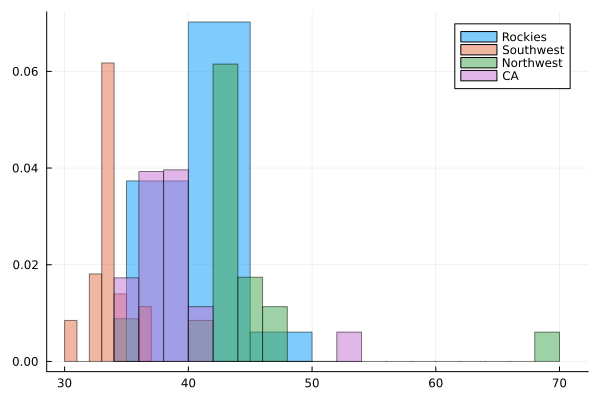

In [24]:
let

    T = Tlimit;

    p1 = [case2["price"][t][1] for t=1:T];
    p2 = [case2["price"][t][2] for t=1:T];
    p3 = [case2["price"][t][3] for t=1:T];
    p4 = [case2["price"][t][4] for t=1:T];
    w = [case2["w"][t] for t=1:T];

    histogram(p4, weights=w, label="Rockies", alpha=.5)
    histogram!(p3, weights=w, label="Southwest", alpha=.5)
    histogram!(p2, weights=w, label="Northwest", alpha=.5)
    histogram!(p1, weights=w, label="CA", alpha=.5)

end

In [25]:
case3 = clear_market_loop(data, tax=17.0, case=3, T=Tlimit);

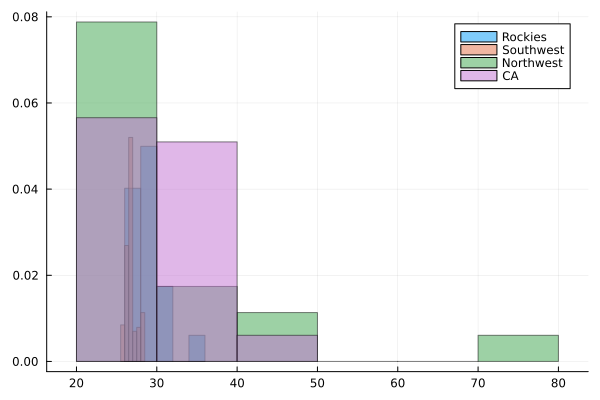

In [25]:
let

    T = Tlimit;

    p1 = [case3["price"][t][1] for t=1:T];
    p2 = [case3["price"][t][2] for t=1:T];
    p3 = [case3["price"][t][3] for t=1:T];
    p4 = [case3["price"][t][4] for t=1:T];
    w = [case3["w"][t] for t=1:T];

    histogram(p4, weights=w, label="Rockies", alpha=.5)
    histogram!(p3, weights=w, label="Southwest", alpha=.5)
    histogram!(p2, weights=w, label="Northwest", alpha=.5)
    histogram!(p1, weights=w, label="CA", alpha=.5)

end

Emissions go away from California in this new setting.

We can compare emissions in California between case2 and case3. 


In [38]:
sum([case2["totale_ca_claimed"][t] for t=1:Tlimit])

77.32212329043035

In [39]:
sum([case3["totale_ca_claimed"][t] for t=1:Tlimit])

38.347976397797844

We can consider the remaining two cases depending on opt-out default and mandatory default, with the mandatory one leading to fewer reshuffling.

In [ ]:
case4 = clear_market_loop(data, tax=17.0, case=4, T=Tlimit);

case5 = clear_market_loop(data, tax=17.0, case=5, T=Tlimit);

In [40]:
sum([case4["totale_ca_claimed"][t] for t=1:Tlimit])

38.3479513026676

In [41]:
sum([case5["totale_ca_claimed"][t] for t=1:Tlimit])

79.16899169800863

This has some benefits to total emissions, although not as large as the difference in claimed emissions.

In [42]:
sum(sum([case4["totale"][t] for t=1:Tlimit]))

285.345134324533

In [43]:
sum(sum([case5["totale"][t] for t=1:Tlimit]))

276.2301829437325

## Follow-up exercises

1. Modify the output code in the market loop so that you can make it a choice in the function: detailed (debugging) output, hourly output, or summary output.

2. Try different default rates for case 5. You will notice that emissions start declining as default rates start increasing, replicating the main figure in the paper. 

3. (*) What are the tensions between balancing leakage and efficiency? Try to show a more comprehensive measure of welfare than  our social planner (who only accounts for taxed emissions).
